In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-notebook')

['bmh', 'classic', 'dark_background', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 
 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 
 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn']


>Import psalter data, header data is in row 1 and index column is set to manuscript id

In [2]:
pslt = pd.read_csv('/Users/jAir/Desktop/SBL Presentations/2018 Ethiopic/PsalterData2.2.csv', header = 1, index_col=1)

>select rows that have complete data (752 rows out of 2058)

In [3]:
pslt1 = pslt.loc[pslt['Complete'] == 1]

>Create new column, century.

In [4]:
conditions = [
    (pslt1['Date_Early'] < 1400),
    (pslt1['Date_Early'] < 1500),
    (pslt1['Date_Early'] < 1600),
    (pslt1['Date_Early'] < 1700),
    (pslt1['Date_Early'] < 1800),
    (pslt1['Date_Early'] < 1900),
    (pslt1['Date_Early'] < 2000)]
choices = ['14th', '15th', '16th', '17th', '18th', '19th', '20th']
pslt1['century'] = np.select(conditions, choices, default='other')

/Users/jAir/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>filter out rows with nan date (748 remaining rows)

In [5]:
pslt2 = pslt1.loc[pslt1['Date_Early'] > 1]

>Some visual EDA: Histogram from Date_Early column (by 'hundreds')

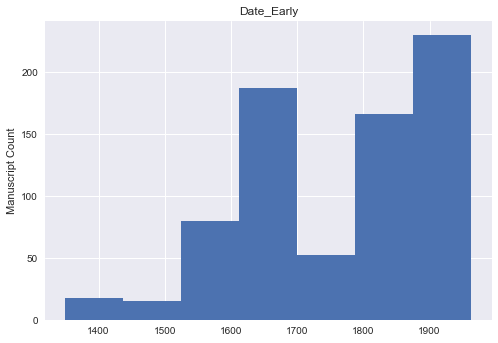

In [6]:
pslt2.hist(column='Date_Early', bins=7)
plt.ylabel('Manuscript Count')
plt.show()

>EDA: bar chart, number of manuscripts date to each century

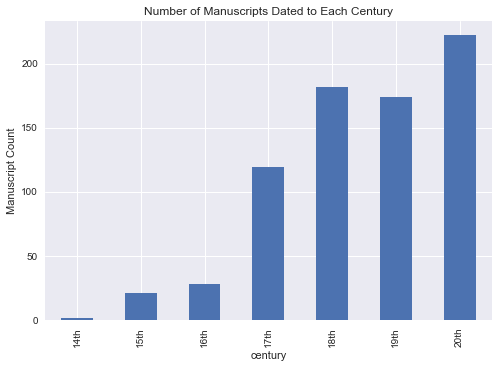

In [7]:
pslt2.groupby('century')['Date_Early'].count().plot(kind='bar')
plt.ylabel('Manuscript Count')
plt.title('Number of Manuscripts Dated to Each Century')
plt.show()

>Area plots: on the left showing number of manuscripts with each variable of each feature; on the right showing the percentage of each variable for each feature

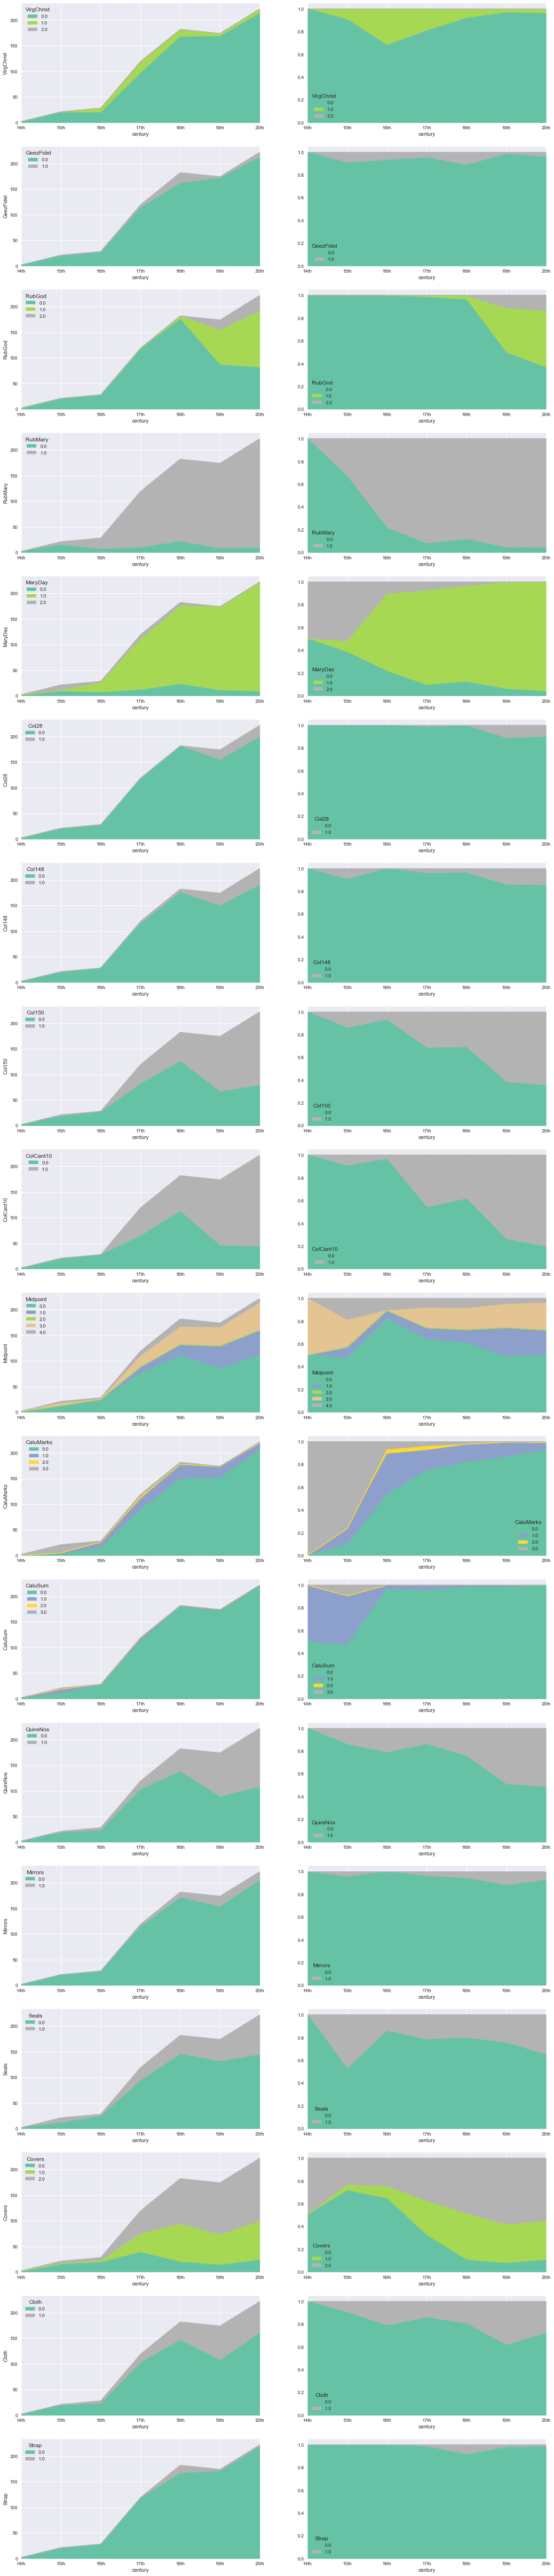

In [8]:
fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(20,100))
axes_list = [item for sublist in axes for item in sublist] 

for column in pslt2.loc[:,'VirgChrist':'Strap']:
    mss_count = pslt2.groupby('century')[column].count()
    ax1 = axes_list.pop(0)
    ax2 = axes_list.pop(0)
    ax1.set_ylabel(column)
    pslt2.groupby(['century', column])[column].count().unstack(level=column).plot.area(cmap='Set2', ax=ax1)
    (pslt2.groupby(['century', column])[column].count()/mss_count).unstack(level=column).plot.area(cmap='Set2', ax=ax2)

plt.show()

In [9]:
pslt2['Date'] = pslt2.loc[:,'Date_Early':'Date_Late'].mean(axis=1)

/Users/jAir/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
pslt3 = pslt2.dropna()

> Decision Tree

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor

In [12]:
X = pslt3.loc[:,'VirgChrist':'Strap']
y = pslt3.loc[:,'Date']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rmse_dt = MSE(y_test, y_pred)
rmse_dt = rmse_dt**(1/2)
print('The Root Mean Square Deviation is:', rmse_dt)

The Root Mean Square Deviation is: 94.40742874877446


In [28]:
from IPython.display import Image  
from sklearn import tree
import pydotplus

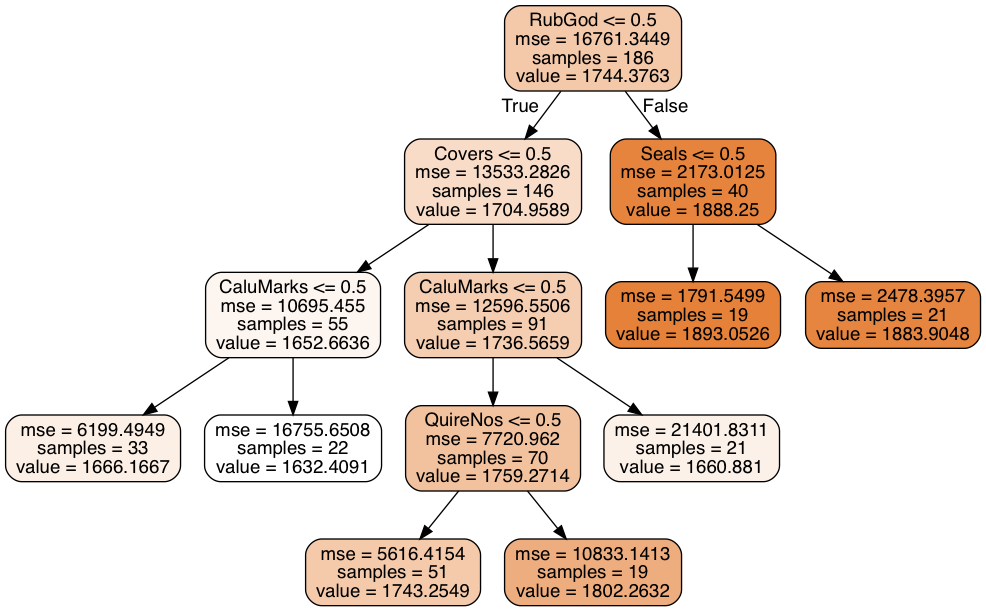

In [40]:
# Create DOT data

variable_names = [
 'VirgChrist',
 'GeezFidel',
 'RubGod',
 'RubMary',
 'MaryDay',
 'Col28',
 'Col148',
 'Col150',
 'ColCant10',
 'Midpoint',
 'CaluMarks',
 'CaluSum',
 'QuireNos',
 'Mirrors',
 'Seals',
 'Covers',
 'Cloth',
 'Strap']

dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=variable_names,
                               filled=True, rounded=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

> Random Forest

In [13]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print("Test set RMSE of rf: {:.2f}".format(rmse_test))

Test set RMSE of rf: 96.68


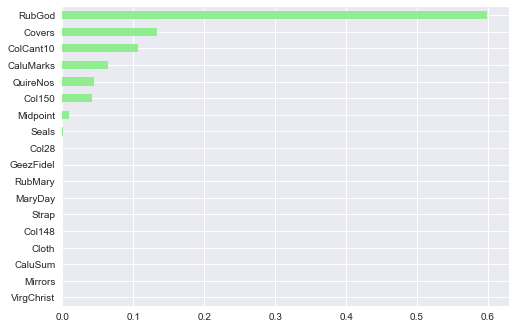

In [14]:
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.show()

> Random Forest with tuned parameters and top five features

In [15]:
X2 = pslt3[['RubGod', 'Covers', 'ColCant10', 'CaluMarks', 'QuireNos']]
y2 = pslt3.loc[:,'Date']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
rf2 = RandomForestRegressor(max_depth = 6, max_features = 'auto', min_samples_leaf = 10, n_estimators = 300, random_state=42)
rf.fit(X_train2, y_train2)
y_pred2 = rf.predict(X_test2)
rmse_test = MSE(y_test2, y_pred2)**(1/2)
print("Test set RMSE of rf2: {:.2f}".format(rmse_test))

Test set RMSE of rf2: 96.35


>Gradient Boosting Classification

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
gbt = GradientBoostingRegressor(n_estimators=300, max_depth=2, random_state=42)
gbt.fit(X_train, y_train)
y_predgbt = gbt.predict(X_test)

rmse_testgbt = MSE(y_test, y_predgbt)**(1/2)
print('Test set RMSE: {:.2f}'.format(rmse_testgbt))

Test set RMSE: 94.50


> Grid Search CV

In [18]:
from sklearn.model_selection import GridSearchCV
params_rf = {
    'n_estimators': [300, 400, 500],
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [10, 25, 50, 100], 
    'max_features': ['auto']}

grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   20.4s finished


Best hyperparameters:
 {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 300}


In [19]:
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
rmse_testgrid = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 96.35


> Predictions Summary

In [20]:
y_df = pd.DataFrame(y_test)

In [21]:
y_df['pred'] = y_pred

In [22]:
y_df['difference'] = abs(y_df.Date-y_df.pred)

In [23]:
y_df.difference.mean()

73.84281159731412

In [24]:
pslt_pred = pd.merge(y_df, pslt3,left_index=True, right_index=True, how='left')

In [25]:
pslt_pred = pslt_pred.loc[:, ['Date_Early', 'Date_Late', 'pred', 'difference']]
pslt_pred['excellent_prediction'] = pslt_pred.eval('pred > Date_Early and pred < Date_Late')
pslt_pred['good_prediction'] = pslt_pred.eval('pred > (Date_Early - 50) and pred < (Date_Late + 50)')
pslt_pred['okay_prediction'] = pslt_pred.eval('pred > (Date_Early - 100) and pred < (Date_Late + 100)')
print('The predicted date is in the range of the paleographic date', 
      pslt_pred.excellent_prediction.sum()/len(pslt_pred.excellent_prediction)*100, 
      'percent of the time' )
print('The predicted date is within 50 years of the range of the paleographic date', 
      pslt_pred.good_prediction.sum()/len(pslt_pred.good_prediction)*100, 
      'percent of the time' )
print('The predicted date is within 100 years of the range of the paleographic date', 
      pslt_pred.okay_prediction.sum()/len(pslt_pred.okay_prediction)*100, 
      'percent of the time' )

The predicted date is in the range of the paleographic date 23.404255319148938 percent of the time
The predicted date is within 50 years of the range of the paleographic date 72.3404255319149 percent of the time
The predicted date is within 100 years of the range of the paleographic date 85.1063829787234 percent of the time


In [26]:
pslt_pred

,Date_Early,Date_Late,pred,difference,excellent_prediction,good_prediction,okay_prediction
ID_1,,,,,,,
EMML 1386,1908.0,1908.0,1885.269225,22.730775,False,True,True
Qeddus Giyorgis Church 30,1600.0,1699.0,1726.964556,77.464556,False,True,True
Toronto Gunda Gunde C3–IV–126,1700.0,1799.0,1885.772583,136.272583,False,False,True
EMDA 00104,1850.0,1949.0,1886.457772,13.042228,True,True,True
EMML 2829,1600.0,1699.0,1625.127218,24.372782,True,True,True
EMML 0081,1850.0,1899.0,1632.285389,242.214611,False,False,False
EMML 0047,1841.0,1852.0,1725.850406,120.649594,False,False,False
EthioSPARE MQM-009,1750.0,1849.0,1810.755978,11.255978,True,True,True
EMML 2600,1600.0,1699.0,1717.833123,68.333123,False,True,True


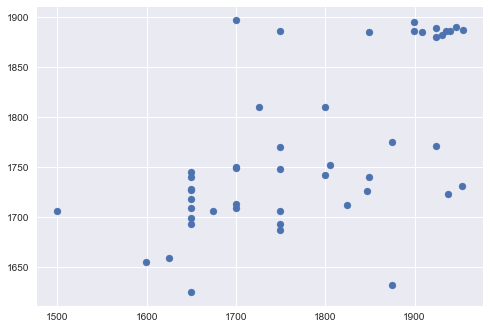

In [27]:
plt.scatter(pslt_pred.loc[:,'Date_Early':'Date_Late'].mean(axis=1), pslt_pred.pred)
plt.show()